# import necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from matplotlib import pyplot as plt
import PIL

# prepare in cifar 100 dataset

In [2]:
NUM_TRAIN = 49000
batch_size= 2000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.

#===========================================================================#
# You should try changing the transform for the training data to include    #
# data augmentation such as RandmCrop and HorizontalFlip                    #
# when running the final part of the notebook where you have to achieve     #
# as high accuracy as possible on CIFAR-100.                                #
# Of course you will have to re-run this block for the effect to take place #
#===========================================================================#
train_transform = transform = T.Compose([
                T.ToTensor(),
                #T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-100
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar100_train = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                               transform=transform)
loader_train = DataLoader(cifar100_train, batch_size=len(cifar100_train), num_workers=2,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
cifar100_train_x = next(iter(loader_train))[0].numpy()
cifar100_train_y = next(iter(loader_train))[1].numpy()
print("train x: ", cifar100_train_x.shape)
print("train y: ", cifar100_train_y.shape)

cifar100_val = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar100_val, batch_size=len(cifar100_val), num_workers=2, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
cifar100_val_x = next(iter(loader_val))[0].numpy()
cifar100_val_y = next(iter(loader_val))[1].numpy()
print("val x: ", cifar100_val_x.shape)
print("val y: ", cifar100_val_y.shape)

cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar100_test, batch_size=len(cifar100_test), num_workers=2)
cifar100_test_x = next(iter(loader_test))[0].numpy()
cifar100_test_y = next(iter(loader_test))[1].numpy()
print("test x: ", cifar100_test_x.shape)
print("test y: ", cifar100_test_y.shape)

Files already downloaded and verified
train x:  (49000, 3, 32, 32)
train y:  (49000,)
Files already downloaded and verified
val x:  (1000, 3, 32, 32)
val y:  (1000,)
Files already downloaded and verified
test x:  (10000, 3, 32, 32)
test y:  (10000,)


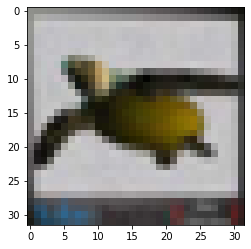

float32


In [3]:
def CHW_to_HWC(x):
    pixels = np.copy(x)
    pixels = np.swapaxes(pixels,0,2)
    pixels = np.swapaxes(pixels,1,0)
    return pixels

def HWC_to_CHW(x):
    pixels = np.copy(x)
    pixels = np.swapaxes(pixels,0,2)
    pixels = np.swapaxes(pixels,1,2)
    return pixels


plt.imshow(CHW_to_HWC(cifar100_train_x[1]))
plt.show()
print(cifar100_train_x.dtype)

# resize images to 128 by 128

(32, 32)
(128, 128)
(128, 128, 3)


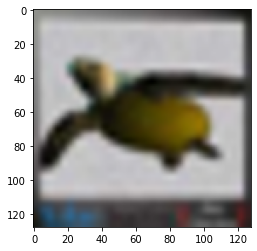

(3, 128, 128)


In [4]:
image = PIL.Image.fromarray(np.uint8(CHW_to_HWC(cifar100_train_x[1]) * 255))
print(image.size)
image = image.resize((int(4 * image.size[0]), int(4 * image.size[1])))
print(image.size)
image = np.array(image)
print(image.shape)
plt.imshow(image)
plt.show()
image = HWC_to_CHW(image)
print(image.shape)

# make 3,128,128 dataset

In [5]:
cifar100_train_x_128 = np.zeros((cifar100_train_x.shape[0],3,128,128))

for i in range(cifar100_train_x.shape[0]):
    image = PIL.Image.fromarray(np.uint8(CHW_to_HWC(cifar100_train_x[i]) * 255))
    image = image.resize((int(4 * image.size[0]), int(4 * image.size[1])))
    image = np.array(image)
    image = HWC_to_CHW(image)
    cifar100_train_x_128[i] = image
    
cifar100_train_x = None

cifar100_val_x_128 = np.zeros((cifar100_val_x.shape[0],3,128,128))
    
for i in range(cifar100_val_x.shape[0]):
    image = PIL.Image.fromarray(np.uint8(CHW_to_HWC(cifar100_val_x[i]) * 255))
    image = image.resize((int(4 * image.size[0]), int(4 * image.size[1])))
    image = np.array(image)
    image = HWC_to_CHW(image)
    cifar100_val_x_128[i] = image
    
cifar100_val_x = None
    
cifar100_test_x_128 = np.zeros((cifar100_test_x.shape[0],3,128,128))
    
for i in range(cifar100_test_x.shape[0]):
    image = PIL.Image.fromarray(np.uint8(CHW_to_HWC(cifar100_test_x[i]) * 255))
    image = image.resize((int(4 * image.size[0]), int(4 * image.size[1])))
    image = np.array(image)
    image = HWC_to_CHW(image)
    cifar100_test_x_128[i] = image
    
cifar100_test_x = None

In [6]:
cifar100_train_x_128 = np.float32(cifar100_train_x_128)
cifar100_train_x_128 = cifar100_train_x_128 / 255.0
cifar100_val_x_128 = np.float32(cifar100_val_x_128)
cifar100_val_x_128 = cifar100_val_x_128 / 255.0
cifar100_test_x_128 = np.float32(cifar100_test_x_128)
cifar100_test_x_128 = cifar100_test_x_128 / 255.0

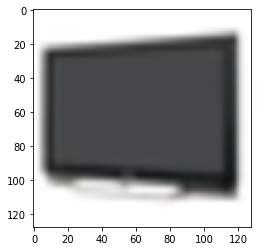

float32


In [7]:
plt.imshow(CHW_to_HWC(cifar100_train_x_128[500]))
plt.show()
print(cifar100_train_x_128.dtype)

In [8]:
cifar100_train_x_128 = torch.from_numpy(cifar100_train_x_128)
cifar100_train_y_128 = torch.from_numpy(cifar100_train_y)
cifar100_val_x_128 = torch.from_numpy(cifar100_val_x_128)
cifar100_val_y_128 = torch.from_numpy(cifar100_val_y)
cifar100_test_x_128 = torch.from_numpy(cifar100_test_x_128)
cifar100_test_y_128 = torch.from_numpy(cifar100_test_y)

In [9]:
print(cifar100_train_x_128.type())
print(cifar100_train_y_128.type())
print(cifar100_val_x_128.type())
print(cifar100_val_y_128.type())
print(cifar100_test_x_128.type())
print(cifar100_test_y_128.type())

torch.FloatTensor
torch.LongTensor
torch.FloatTensor
torch.LongTensor
torch.FloatTensor
torch.LongTensor


In [10]:
# print(cifar100_train_x_128[0:9800,:,:,:].size())
# print(cifar100_train_x_128[9800:19600,:,:,:].size())
# print(cifar100_train_x_128[19600:29400,:,:,:].size())
# print(cifar100_train_x_128[29400:39200,:,:,:].size())
# print(cifar100_train_x_128[39200:49000,:,:,:].size())

In [11]:
cifar100_train_x_128_1 = torch.clone(cifar100_train_x_128[0:9800,:,:,:])
cifar100_train_x_128_2 = torch.clone(cifar100_train_x_128[9800:19600,:,:,:])
cifar100_train_x_128_3 = torch.clone(cifar100_train_x_128[19600:29400,:,:,:])
cifar100_train_x_128_4 = torch.clone(cifar100_train_x_128[29400:39200,:,:,:])
cifar100_train_x_128_5 = torch.clone(cifar100_train_x_128[39200:49000,:,:,:])
torch.save(cifar100_train_x_128_1, 'cifar100_train_x_128_1.pt')
torch.save(cifar100_train_x_128_2, 'cifar100_train_x_128_2.pt')
torch.save(cifar100_train_x_128_3, 'cifar100_train_x_128_3.pt')
torch.save(cifar100_train_x_128_4, 'cifar100_train_x_128_4.pt')
torch.save(cifar100_train_x_128_5, 'cifar100_train_x_128_5.pt')
torch.save(cifar100_train_y_128, 'cifar100_train_y_128.pt')
torch.save(cifar100_val_x_128, 'cifar100_val_x_128.pt')
torch.save(cifar100_val_y_128, 'cifar100_val_y_128.pt')
torch.save(cifar100_test_x_128, 'cifar100_test_x_128.pt')
torch.save(cifar100_test_y_128, 'cifar100_test_y_128.pt')

In [12]:
# cifar100_train_x_128 = cifar100_train_x_128.numpy().astype(np.float32)
# cifar100_train_y_128 = cifar100_train_y_128.numpy()
# cifar100_val_x_128 = cifar100_val_x_128.numpy().astype(np.float32)
# cifar100_val_y_128 = cifar100_val_y_128.numpy()
# cifar100_test_x_128 = cifar100_test_x_128.numpy().astype(np.float32)
# cifar100_test_y_128 = cifar100_test_y_128.numpy()

In [13]:
# np.save('cifar100_train_x_128', cifar100_train_x_128)
# np.save('cifar100_train_y_128', cifar100_train_y_128)
# np.save('cifar100_val_x_128', cifar100_val_x_128)
# np.save('cifar100_val_y_128', cifar100_val_y_128)
# np.save('cifar100_test_x_128', cifar100_test_x_128)
# np.save('cifar100_test_y_128', cifar100_test_y_128)